# **DEEP NEURAL COMPRESSION FOR NEURAL STYLE TRANSFER**

### **IMPORTS AND INITIALIZATIONS**

In [1]:
# Import!
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
import cv2
import copy

import math
import random
from torch.optim.lr_scheduler import *
from tqdm.auto import tqdm


/home/ilesh-dhall/Mini_Project_Sem_3/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Hyperparameters
MAX_IMAGE_SIZE = 512
OPTIMIZER = 'adam'
ADAM_LR = 10
CONTENT_WEIGHT = 5e0
STYLE_WEIGHT = 1e2
TV_WEIGHT = 1e-3
NUM_ITER = 500
SHOW_ITER = 100
INIT_IMAGE = 'random'
CONTENT_PATH = 'images/content-1.png'
STYLE_PATH = 'images/style-1.jpg'
VGG19_PATH = 'models/vgg19-d01eb7cb.pth'
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [6]:
# Load VGG19 Skeleton and Weights
vgg = models.vgg19(pretrained=False)
vgg.load_state_dict(torch.load(VGG19_PATH, weights_only=False), strict=False)
model = copy.deepcopy(vgg.features)
model.to(device)

# Turn off unnecessary gradients
for param in model.parameters():
    param.requires_grad = False

/home/ilesh-dhall/Mini_Project_Sem_3/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ilesh-dhall/Mini_Project_Sem_3/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### **HELPER FUNCTIONS**

In [7]:
def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [8]:
# Utility Functions
def load_image(path):
    img = cv2.imread(path)
    return img

def show(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img / 255).clip(0, 1)
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def itot(img):
    H, W, C = img.shape
    image_size = tuple([int((float(MAX_IMAGE_SIZE) / max([H, W])) * x) for x in [H, W]])
    itot_t = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    normalize_t = transforms.Normalize([103.939, 116.779, 123.68], [1, 1, 1])
    tensor = normalize_t(itot_t(img) * 255)
    tensor = tensor.unsqueeze(dim=0)
    return tensor

def ttoi(tensor):
    ttoi_t = transforms.Compose([
        transforms.Normalize([-103.939, -116.779, -123.68], [1, 1, 1])])
    tensor = tensor.squeeze()
    img = ttoi_t(tensor)
    img = img.cpu().numpy()
    img = img.transpose(1, 2, 0)
    return img

In [9]:
# Define loss functions
mse_loss = torch.nn.MSELoss()
def gram(tensor):
    B, C, H, W = tensor.shape
    x = tensor.view(C, H * W)
    return torch.mm(x, x.t())

def content_loss(g, c):
    return mse_loss(g, c)

def style_loss(g, s):
    c1, c2 = g.shape
    return mse_loss(g, s) / (c1 ** 2)

def tv_loss(c):
    x = c[:, :, 1:, :] - c[:, :, :-1, :]
    y = c[:, :, :, 1:] - c[:, :, :, :-1]
    return torch.sum(torch.abs(x)) + torch.sum(torch.abs(y))

In [10]:
# VGG Forward Pass
def get_features(model, tensor):
    layers = {
        '3': 'relu1_2',
        '8': 'relu2_2',
        '17': 'relu3_3',
        '26': 'relu4_3',
        '35': 'relu5_3',
        '22': 'relu4_2',
    }
    features = {}
    x = tensor
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            if name == '22':
                features[layers[name]] = x
            else:
                b, c, h, w = x.shape
                features[layers[name]] = gram(x) / (h * w)
            if name == '35':
                break
    return features

# Generate initial image
def initial(content_tensor, init_image='random'):
    B, C, H, W = content_tensor.shape
    if init_image == 'random':
        tensor = torch.randn(C, H, W).mul(0.001).unsqueeze(0)
    else:
        tensor = content_tensor.clone().detach()
    return tensor

In [11]:
def evaluate(
    model: nn.Module,
    iteration: int = NUM_ITER,
) -> tuple:
    # Initialize the necessary variables
    optimizer = optim.Adam([g], lr=ADAM_LR)
    final_total_loss = None  # To store the final total loss after all iterations
    final_content_loss = None  # To store the final content loss
    final_style_loss = None  # To store the final style loss
    final_tv_loss = None  # To store the final TV loss

    # Set content and style layers/weights
    content_layers = ['relu4_2']
    content_weights = {'relu4_2': 1.0}
    style_layers = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3']
    style_weights = {'relu1_2': 0.2, 'relu2_2': 0.2, 'relu3_3': 0.2, 'relu4_3': 0.2, 'relu5_3': 0.2}

    # Extract content and style features using the simple model
    c_feat = get_features(model, content_tensor)
    s_feat = get_features(model, style_tensor)

    # Initialize loss tracker
    total_loss = 0

    # Start the optimization loop with tqdm for progress tracking
    for i in tqdm(range(iteration), desc="NST evaluation", leave=False):
        def closure():
            # Zero-out gradients
            optimizer.zero_grad()

            # Forward pass using the simple model
            g_feat = get_features(model, g)

            # Compute the content and style losses
            c_loss = 0
            s_loss = 0
            for j in content_layers:
                c_loss += content_weights[j] * content_loss(g_feat[j], c_feat[j])
            for j in style_layers:
                s_loss += style_weights[j] * style_loss(g_feat[j], s_feat[j])

            c_loss = CONTENT_WEIGHT * c_loss
            s_loss = STYLE_WEIGHT * s_loss
            t_loss = TV_WEIGHT * tv_loss(g.clone().detach())

            # Total loss
            total_loss = c_loss + s_loss + t_loss

            # Backpropagate the total loss
            total_loss.backward(retain_graph=True)

            # Track the total loss
            if i % SHOW_ITER == 0 or i == iteration:
                print(f"Iteration {i}: Content Loss: {c_loss.item()}, Style Loss: {s_loss.item()}, TV Loss: {t_loss.item()}, Total Loss: {total_loss.item()}")

            # Store the final content and style losses from this iteration
            nonlocal final_total_loss, final_content_loss, final_style_loss, final_tv_loss
            final_total_loss = total_loss.item()
            final_content_loss = c_loss.item()
            final_style_loss = s_loss.item()
            final_tv_loss = t_loss.item()

            return total_loss

        # Update weights/pixels using the optimizer
        optimizer.step(closure)

    # Convert tensor to image format and show
    g_ = ttoi(g.clone().detach())
    show(g_)

    return final_total_loss, final_content_loss, final_style_loss, final_tv_loss


In [12]:
# Load Images, Tensors and Gram Matrix
content_img = load_image(CONTENT_PATH)
style_img = load_image(STYLE_PATH)

content_tensor = itot(content_img).to(device)
style_tensor = itot(style_img).to(device)
g = initial(content_tensor, init_image=INIT_IMAGE).to(device).requires_grad_(True)

### **INPUT VISUALIZATION**

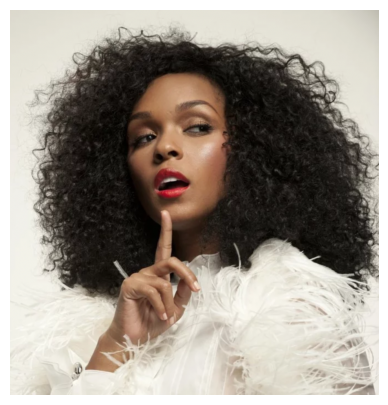

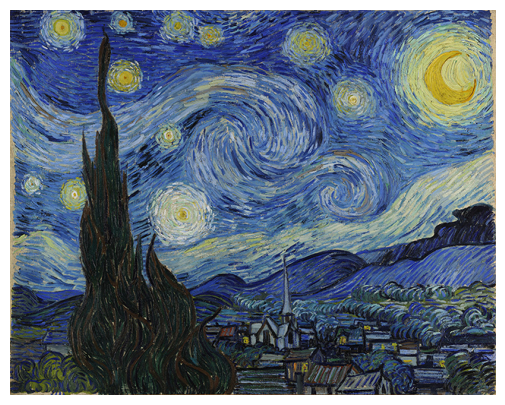

In [13]:
# Show Images
show(content_img)
show(style_img)

### **DENSE MODEL EVALUATION AND VISUALIZATIONS**

NST evaluation:   0%|          | 2/500 [00:00<01:37,  5.13it/s]

Iteration 0: Content Loss: 1237537.625, Style Loss: 63067568.0, TV Loss: 1.6960008144378662, Total Loss: 64305104.0


NST evaluation:  20%|██        | 102/500 [00:16<01:14,  5.37it/s]

Iteration 100: Content Loss: 872268.0, Style Loss: 290496.6875, TV Loss: 31109.490234375, Total Loss: 1193874.25


NST evaluation:  40%|████      | 202/500 [00:30<00:40,  7.41it/s]

Iteration 200: Content Loss: 713537.875, Style Loss: 192868.421875, TV Loss: 31201.033203125, Total Loss: 937607.375


NST evaluation:  60%|██████    | 302/500 [00:43<00:26,  7.44it/s]

Iteration 300: Content Loss: 688495.25, Style Loss: 199914.984375, TV Loss: 31915.775390625, Total Loss: 920326.0


NST evaluation:  80%|████████  | 402/500 [01:00<00:13,  7.34it/s]

Iteration 400: Content Loss: 620761.5625, Style Loss: 124375.671875, TV Loss: 32033.015625, Total Loss: 777170.25


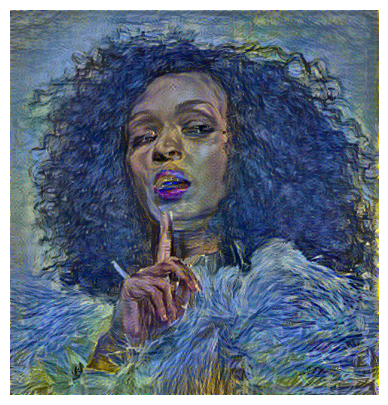

Dense Model Content Loss = 609306.31
Dense Model Style Loss = 218365.84
Dense Model Total Variation Loss = 32577.24
Dense Model Total Loss = 860249.38
Dense Model Size = 76.39 MiB


In [14]:
dense_model_total_loss, dense_model_content_loss, dense_model_style_loss, dense_model_tv_loss = evaluate(model, NUM_ITER)
dense_model_size = get_model_size(model)
print(f"Dense Model Content Loss = {dense_model_content_loss:.2f}")
print(f"Dense Model Style Loss = {dense_model_style_loss:.2f}")
print(f"Dense Model Total Variation Loss = {dense_model_tv_loss:.2f}")
print(f"Dense Model Total Loss = {dense_model_total_loss:.2f}")
print(f"Dense Model Size = {dense_model_size/MiB:.2f} MiB")

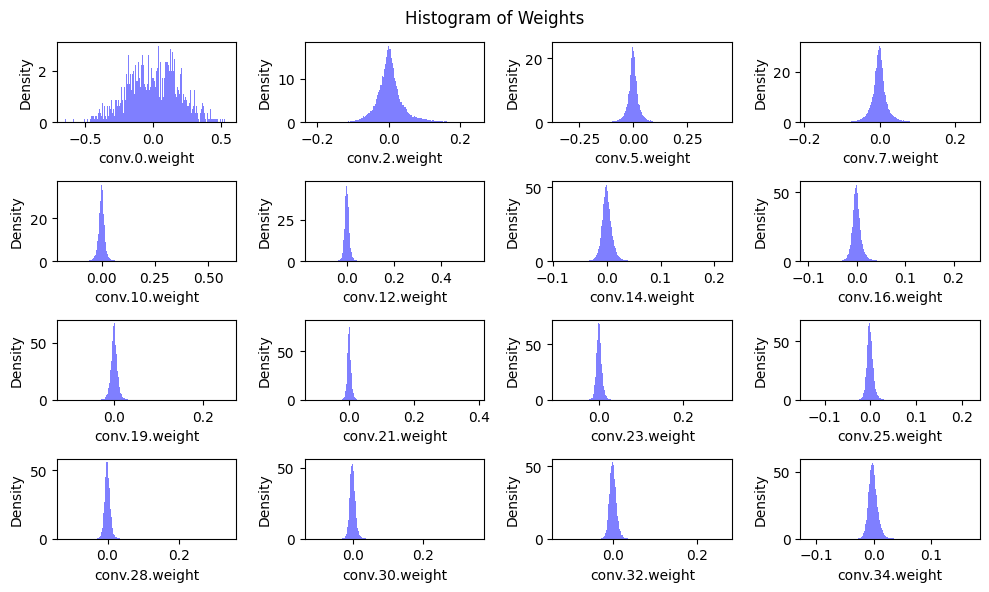

In [15]:
# Plotting Weight Distribution For Each Layer
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(4, 4, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0

    for name, param in model.named_parameters():
        if param.dim() > 1:  # Only plot weights (ignoring biases)
            ax = axes[plot_index]

            # Plot the weights
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True, color='blue', alpha=0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True, color='blue', alpha=0.5)

            ax.set_xlabel(f'conv.{name}')
            ax.set_ylabel('Density')
            plot_index += 1

    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()
plot_weight_distribution(model)

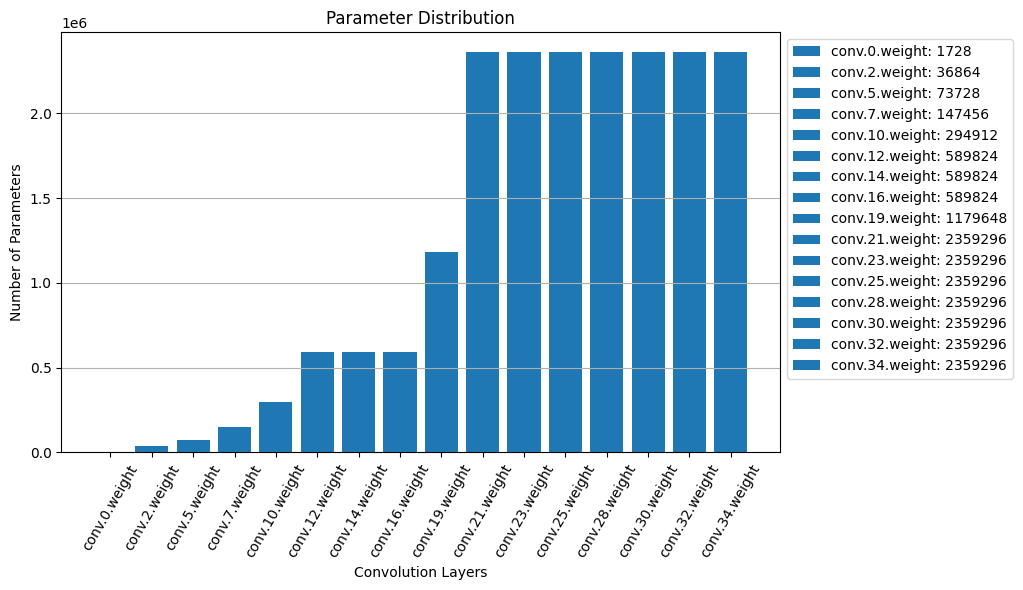

In [16]:
# Plotting Parameter Distribution In Each Layer
def plot_num_parameters_distribution(model, count_non_zero=False):
    num_parameters = dict()
    non_zero_parameters = dict()

    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
            if count_non_zero:
                non_zero_parameters[name] = (param != 0).sum().item()  # Count non-zero elements

    # If count_non_zero is True, graph only non-zero parameters
    if count_non_zero:
        num_parameters = non_zero_parameters  # Update to plot only non-zero parameters

    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    x_labels = [f"conv.{name}" for name in num_parameters.keys()]
    bars = plt.bar(x_labels, list(num_parameters.values()))
    plt.title('Parameter Distribution')
    plt.xlabel("Convolution Layers")
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()

    # Create legend with the number of parameters and optional non-zero weights for each layer
    if count_non_zero:
        legend_labels = [f"conv.{name}: {non_zero_parameters[name]}"
                         for name, param in num_parameters.items()]
    else:
        legend_labels = [f"conv.{name}: {param}" for name, param in num_parameters.items()]

    plt.legend(bars, legend_labels, loc='upper left', bbox_to_anchor=(1, 1))

    plt.show()

# Call the function with count_non_zero set to True to graph non-zero counts
plot_num_parameters_distribution(model, count_non_zero=False)


### **PRUNED MODEL EVALUATION AND VISUALIZATIONS**

In [17]:
# Define fine-grained pruning function
def fine_grained_prune(tensor: torch.Tensor, sparsity: float) -> torch.Tensor:
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()
    num_zeros = round(sparsity * num_elements)
    importance = tensor.abs()
    threshold = torch.kthvalue(importance.view(-1), num_zeros).values
    mask = importance.gt(threshold)  # 1 if importance > threshold, 0 otherwise
    tensor.mul_(mask)  # Apply mask to prune the tensor

    return mask


# Fine-grained pruner class
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1:  # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks


Pruning the model...
Model pruned.


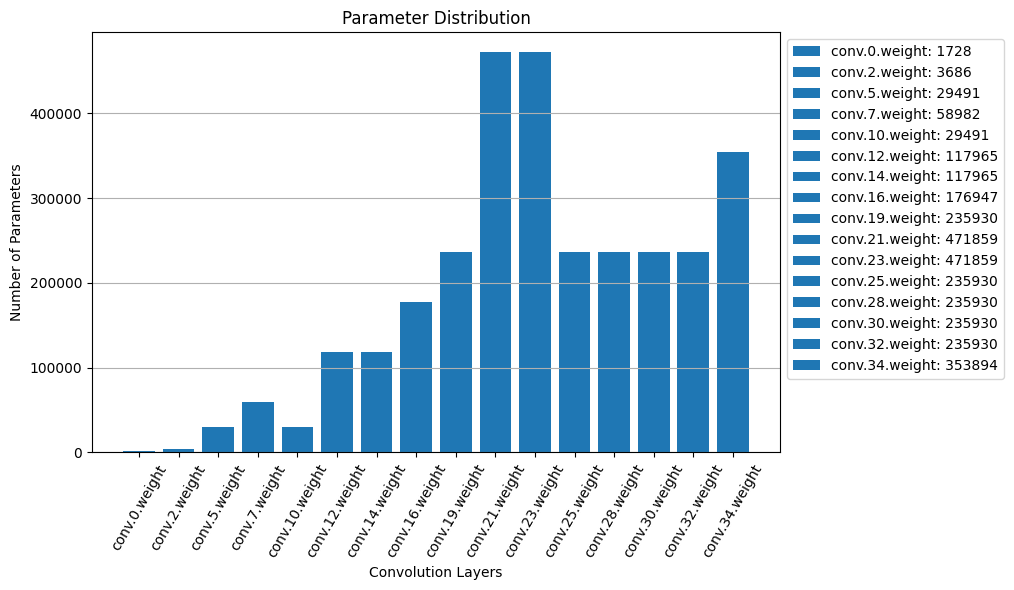

Pruned model has size = 11.52 MiB
The pruned model is 84.92% smaller in size than the dense model.


In [18]:
# Define the target sparsity for each layer in a dictionary
sparsity_dict = {
    '0.weight': 0.0,
    '2.weight': 0.9,
    '5.weight': 0.6,
    '7.weight': 0.6,
    '10.weight': 0.9,
    '12.weight': 0.8,
    '14.weight': 0.8,
    '16.weight': 0.7,
    '19.weight': 0.8,
    '21.weight': 0.8,
    '23.weight': 0.8,
    '25.weight': 0.9,
    '28.weight': 0.9,
    '30.weight': 0.9,
    '32.weight': 0.9,
    '34.weight': 0.85,
}

# Create a deep copy of the model to retain the original
pruned_model = copy.deepcopy(model)

# Initialize the pruner with the model and sparsity_dict
pruner = FineGrainedPruner(pruned_model, sparsity_dict)

# Apply pruning to the model
print("Pruning the model...")
pruner.apply(pruned_model)
print("Model pruned.")

# Save pruned model
torch.save(pruned_model.state_dict(), 'models/pruned_model.pth')

plot_num_parameters_distribution(pruned_model, count_non_zero=True)
pruned_model_size = get_model_size(pruned_model, count_nonzero_only=True)
print(f"Pruned model has size = {pruned_model_size/MiB:.2f} MiB")
pruned_percentage = 100 * (1 - pruned_model_size / dense_model_size)
print(f"The pruned model is {pruned_percentage:.2f}% smaller in size than the dense model.")


NST evaluation:   0%|          | 2/500 [00:00<02:20,  3.53it/s]

Iteration 0: Content Loss: 692286.75, Style Loss: 6708498.5, TV Loss: 32652.701171875, Total Loss: 7433437.5


NST evaluation:  20%|██        | 102/500 [00:16<00:52,  7.51it/s]

Iteration 100: Content Loss: 303924.40625, Style Loss: 49788.05859375, TV Loss: 39914.234375, Total Loss: 393626.6875


NST evaluation:  40%|████      | 202/500 [00:30<00:39,  7.51it/s]

Iteration 200: Content Loss: 252919.859375, Style Loss: 47737.60546875, TV Loss: 38633.48828125, Total Loss: 339290.96875


NST evaluation:  60%|██████    | 302/500 [00:43<00:26,  7.49it/s]

Iteration 300: Content Loss: 236772.03125, Style Loss: 49862.38671875, TV Loss: 38298.6953125, Total Loss: 324933.09375


NST evaluation:  80%|████████  | 402/500 [01:00<00:13,  7.47it/s]

Iteration 400: Content Loss: 226649.53125, Style Loss: 67805.9296875, TV Loss: 38169.81640625, Total Loss: 332625.28125


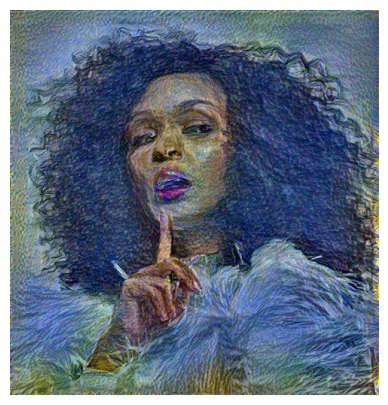

Pruned Model Content Loss = 221417.67
Pruned Model Style Loss = 73299.69
Pruned Model Total Variation Loss = 38133.54
Pruned Model Total Loss = 332850.91


In [19]:
# Displaying NST Result After Pruning
pruned_model_total_loss, pruned_model_content_loss, pruned_model_style_loss, pruned_model_tv_loss = evaluate(pruned_model, NUM_ITER)
print(f"Pruned Model Content Loss = {pruned_model_content_loss:.2f}")
print(f"Pruned Model Style Loss = {pruned_model_style_loss:.2f}")
print(f"Pruned Model Total Variation Loss = {pruned_model_tv_loss:.2f}")
print(f"Pruned Model Total Loss = {pruned_model_total_loss:.2f}")

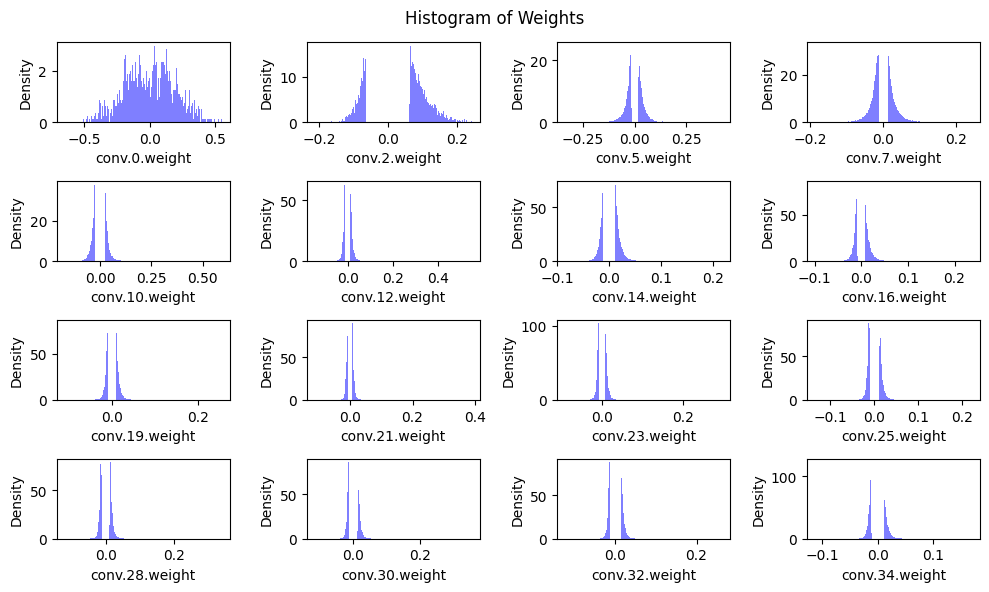

In [20]:
# Pruned Model Weight Distribution
plot_weight_distribution(pruned_model, count_nonzero_only=True)

### **FINE TUNING**

Finetuning Fine-grained Pruned Sparse Model


NST evaluation:   0%|          | 0/200 [00:00<?, ?it/s]

NST evaluation:   1%|          | 2/200 [00:00<00:51,  3.85it/s]

Iteration 0: Content Loss: 240950.25, Style Loss: 521.1859741210938, TV Loss: 382174.65625, Total Loss: 623646.125


NST evaluation:  51%|█████     | 102/200 [00:14<00:13,  7.36it/s]

Iteration 100: Content Loss: 191352.359375, Style Loss: 5191.79541015625, TV Loss: 380643.65625, Total Loss: 577187.8125


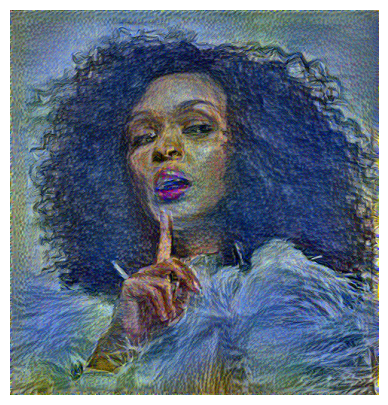

Fine Tuned Model Content Loss = 160201.48
Fine Tuned Model Style Loss = 16634.80
Fine Tuned Model Total Variation Loss = 379670.12
Fine Tuned Model Total Loss = 556506.38


In [21]:
# Change According to Requirement
ADAM_LR = 1e-2
CONTENT_WEIGHT = 5e0
STYLE_WEIGHT = 1e0
TV_WEIGHT = 1e-2
NUM_ITER = 200

# Fine-tune the model
print(f'Finetuning Fine-grained Pruned Sparse Model')
ft_model_total_loss, ft_model_content_loss, ft_model_style_loss, ft_model_tv_loss = evaluate(pruned_model, NUM_ITER)
print(f"Fine Tuned Model Content Loss = {ft_model_content_loss:.2f}")
print(f"Fine Tuned Model Style Loss = {ft_model_style_loss:.2f}")
print(f"Fine Tuned Model Total Variation Loss = {ft_model_tv_loss:.2f}")
print(f"Fine Tuned Model Total Loss = {ft_model_total_loss:.2f}")


### **SENSITIVITY ANALYSIS**

In [17]:
def sensitivity_scan(model, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True, selected_layers=None):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    content_losses = []  # List to store content losses at each sparsity
    style_losses = []      # List to store style losses at each sparsity
    tv_losses = []          # List to store tv losses at each sparsity
    total_losses = []      # List to store total losses at each sparsity

    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]

    if selected_layers is not None:
        # Filter named_conv_weights to include only the selected layers
        named_conv_weights = [(name, param) for name, param in named_conv_weights if name in selected_layers]

    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        total_loss = []       # Temporarily store total losses for this layer
        content_loss = []  # Temporarily store content losses for this layer
        style_loss = []      # Temporarily store style losses for this layer
        tv_loss = []          # Temporarily store tv losses for this layer

        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)

            tl, cl, sl, tvl = evaluate(model, NUM_ITER)  # Expecting total, content, style and tv losses
            if verbose:
                print(f'\r    sparsity = {sparsity:.2f}: total loss = {tl}, content loss = {cl}, style loss = {sl}, total variation loss = {tvl}',  end='')

            # restore
            param.data.copy_(param_clone)

            # Append the losses to the respective lists
            content_loss.append(cl)
            style_loss.append(sl)
            tv_loss.append(tvl)
            total_loss.append(tl)

        # Store the losses for this layer
        total_losses.append(total_loss)
        content_losses.append(content_loss)
        style_losses.append(style_loss)
        tv_losses.append(tv_loss)

        if verbose:
            print(f'\r    sparsities = [{", ".join(["{:.2f}".format(x) for x in sparsities])}], content losses = [{", ".join([str(x) for x in content_loss])}], style losses = [{", ".join([str(x) for x in style_loss])}], tv losses = [{", ".join([str(x) for x in tv_loss])}], total losses = [{", ".join([str(x) for x in total_loss])}]', end='')

    return sparsities, content_losses, style_losses, tv_losses, total_losses


In [ ]:
sparsities, content_losses, style_losses, tv_losses, total_losses = sensitivity_scan(
    model, scan_step=0.1, scan_start=0.4, scan_end=1.0, selected_layers = None)

In [20]:
# Values Obtained After Performing Sensitivity Scan
sparsities=[0.40, 0.50, 0.60, 0.70, 0.80, 0.90]

content_losses = [
    [454623.25, 395463.125, 376287.34375, 338813.0625, 162886.421875, 79779.0546875],
    [575870.1875, 491000.375, 454014.125, 392748.0, 403879.53125, 288066.0],
    [462719.125, 406145.375, 369411.9375, 289289.21875, 239406.0, 167335.453125],
    [480726.09375, 469944.53125, 424009.71875, 409492.25, 393944.9375, 314280.4375],
    [548330.9375, 496286.59375, 459528.28125, 420399.5, 866575.875, 444679.96875],
    [542341.8125, 532150.8125, 534224.3125, 529544.125, 488758.0, 1225982.0],
    [517581.25, 510357.8125, 460067.65625, 457310.375, 343343.625, 221200.96875],
    [526146.3125, 521807.4375, 539002.875, 546159.875, 441345.03125, 349844.3125],
    [538071.1875, 527466.75, 519512.03125, 502808.4375, 445062.875, 309697.0625],
    [563715.125, 551157.9375, 586112.625, 592357.0, 592386.1875, 448189.71875],
    [559268.0, 563044.625, 521379.03125, 512610.5625, 522440.03125, 532236.75],
    [524868.25, 517486.875, 550960.75, 544010.5625, 538322.0625, 555494.5625],
    [527734.9375, 519227.34375, 514477.34375, 502447.25, 573471.25, 519334.9375],
    [518398.90625, 559693.625, 554284.5, 523020.875, 530037.3125, 526390.25],
    [567564.6875, 575252.1875, 552397.0625, 566668.375, 552023.0625, 653123.0625],
    [514259.09375, 512984.40625, 520277.375, 515237.6875, 507410.0625, 521713.09375]
]

style_losses = [
    [71847.3125, 59440.59375, 58305.1953125, 78482.9375, 35526.578125, 20491.15234375],
    [93348.3125, 87081.9609375, 72709.78125, 67841.2265625, 83435.890625, 70729.75],
    [86045.578125, 140351.3125, 164724.4375, 64811.40234375, 43663.26171875, 28038.16796875],
    [172904.234375, 105111.1328125, 78929.0078125, 90134.984375, 94155.234375, 53349.953125],
    [246667.234375, 86891.8359375, 111514.734375, 80303.125, 1075858.875, 92650.0],
    [94431.4921875, 93045.734375, 93446.8125, 140983.03125, 81873.359375, 1889261.0],
    [89622.7890625, 89365.375, 80816.953125, 225250.78125, 57873.296875, 37185.8203125],
    [104278.25, 87211.3125, 75503.03125, 149331.65625, 226363.84375, 47531.44140625],
    [85336.421875, 136756.234375, 88405.9296875, 68740.890625, 60693.25390625, 47511.00390625],
    [83788.0234375, 84703.390625, 94830.140625, 87118.875, 85555.8046875, 79233.890625],
    [80418.90625, 81879.84375, 112481.234375, 130194.3359375, 124683.0234375, 86253.2109375],
    [99353.609375, 86592.234375, 273257.3125, 99558.3203125, 86431.1484375, 109306.15625],
    [115158.9609375, 127782.09375, 142790.265625, 230115.546875, 138439.65625, 92879.703125],
    [123765.25, 122266.7578125, 97455.7265625, 86378.46875, 91296.796875, 90194.7421875],
    [86869.296875, 89444.328125, 84695.6328125, 82126.6953125, 105989.453125, 186617.578125],
    [174985.265625, 112086.046875, 89433.890625, 84654.0625, 116942.3125, 243014.5]
]

tv_losses = [
    [42060.3125, 49848.7734375, 56718.4921875, 62237.12109375, 68672.75, 77869.9140625],
    [79476.3203125, 78246.140625, 79939.7421875, 82524.7578125, 82244.7265625, 81965.5546875],
    [82262.9140625, 82842.7890625, 83379.828125, 84457.1875, 85037.8828125, 87511.234375],
    [88509.09375, 88925.75, 91200.421875, 92148.4765625, 92696.5625, 93638.6953125],
    [93746.15625, 94249.421875, 95035.4453125, 96939.8046875, 99452.2265625, 98228.9765625],
    [99700.46875, 101598.9375, 101915.265625, 102489.4921875, 104405.78125, 109938.625],
    [105914.6484375, 107159.2109375, 108543.0, 108822.375, 109190.2265625, 110674.78125],
    [111116.2421875, 112366.328125, 114697.65625, 115116.6015625, 115268.984375, 117287.25],
    [118975.4921875, 119083.3046875, 119273.296875, 121028.1171875, 123287.3125, 124320.6953125],
    [65297.82421875, 66486.28125, 69769.0390625, 73495.328125, 77162.53125, 82942.0859375],
    [86642.3359375, 89811.2734375, 89982.5703125, 90764.53125, 91316.7265625, 92169.8125],
    [94024.1875, 95489.0, 96171.9453125, 98018.359375, 100244.0859375, 100601.2421875],
    [101096.75, 102219.8203125, 102525.7890625, 102899.078125, 103363.3828125, 103804.9296875],
    [104433.8203125, 105246.0, 105612.8984375, 106722.7109375, 108076.0390625, 109867.8203125],
    [40312.0546875, 46165.78125, 50863.69921875, 56435.71484375, 58105.98046875, 60296.45703125],
    [60916.06640625, 62125.5234375, 64169.28125, 65825.1015625, 67273.828125, 68573.234375]
]

total_losses = [
    [568530.875, 504752.5, 491311.03125, 479533.125, 267085.75, 178140.125],
    [748694.8125, 656328.4375, 606663.625, 543114.0, 569560.1875, 440761.3125],
    [631027.625, 629339.5, 617516.1875, 438557.8125, 368107.125, 282884.875],
    [742139.375, 663981.4375, 594139.125, 591775.75, 580796.75, 461269.0625],
    [888744.375, 677427.875, 666078.4375, 597642.4375, 2041887.0, 635559.0],
    [736473.75, 726795.5, 729586.375, 773016.625, 675037.125, 3225181.5],
    [713118.6875, 706882.375, 649427.625, 791383.5, 510407.15625, 369061.5625],
    [741540.8125, 721385.0625, 729203.5, 810608.125, 782977.875, 514663.0],
    [742383.125, 783306.3125, 727191.25, 692577.4375, 629043.4375, 481528.75],
    [712800.9375, 702347.625, 750711.8125, 752971.1875, 755104.5, 610365.6875],
    [726329.1875, 734735.75, 723842.8125, 733569.375, 738439.8125, 710659.75],
    [718246.0625, 699568.125, 920390.0, 741587.25, 724997.25, 765402.0],
    [743990.625, 749229.25, 759793.4375, 835461.875, 815274.25, 716019.5625],
    [746597.9375, 787206.375, 757353.125, 716122.0625, 729410.1875, 726452.8125],
    [694746.0625, 710862.25, 687956.375, 705230.75, 716118.5, 900037.0625],
    [750160.4375, 687195.9375, 673880.5, 665716.875, 691626.1875, 833300.875]
]


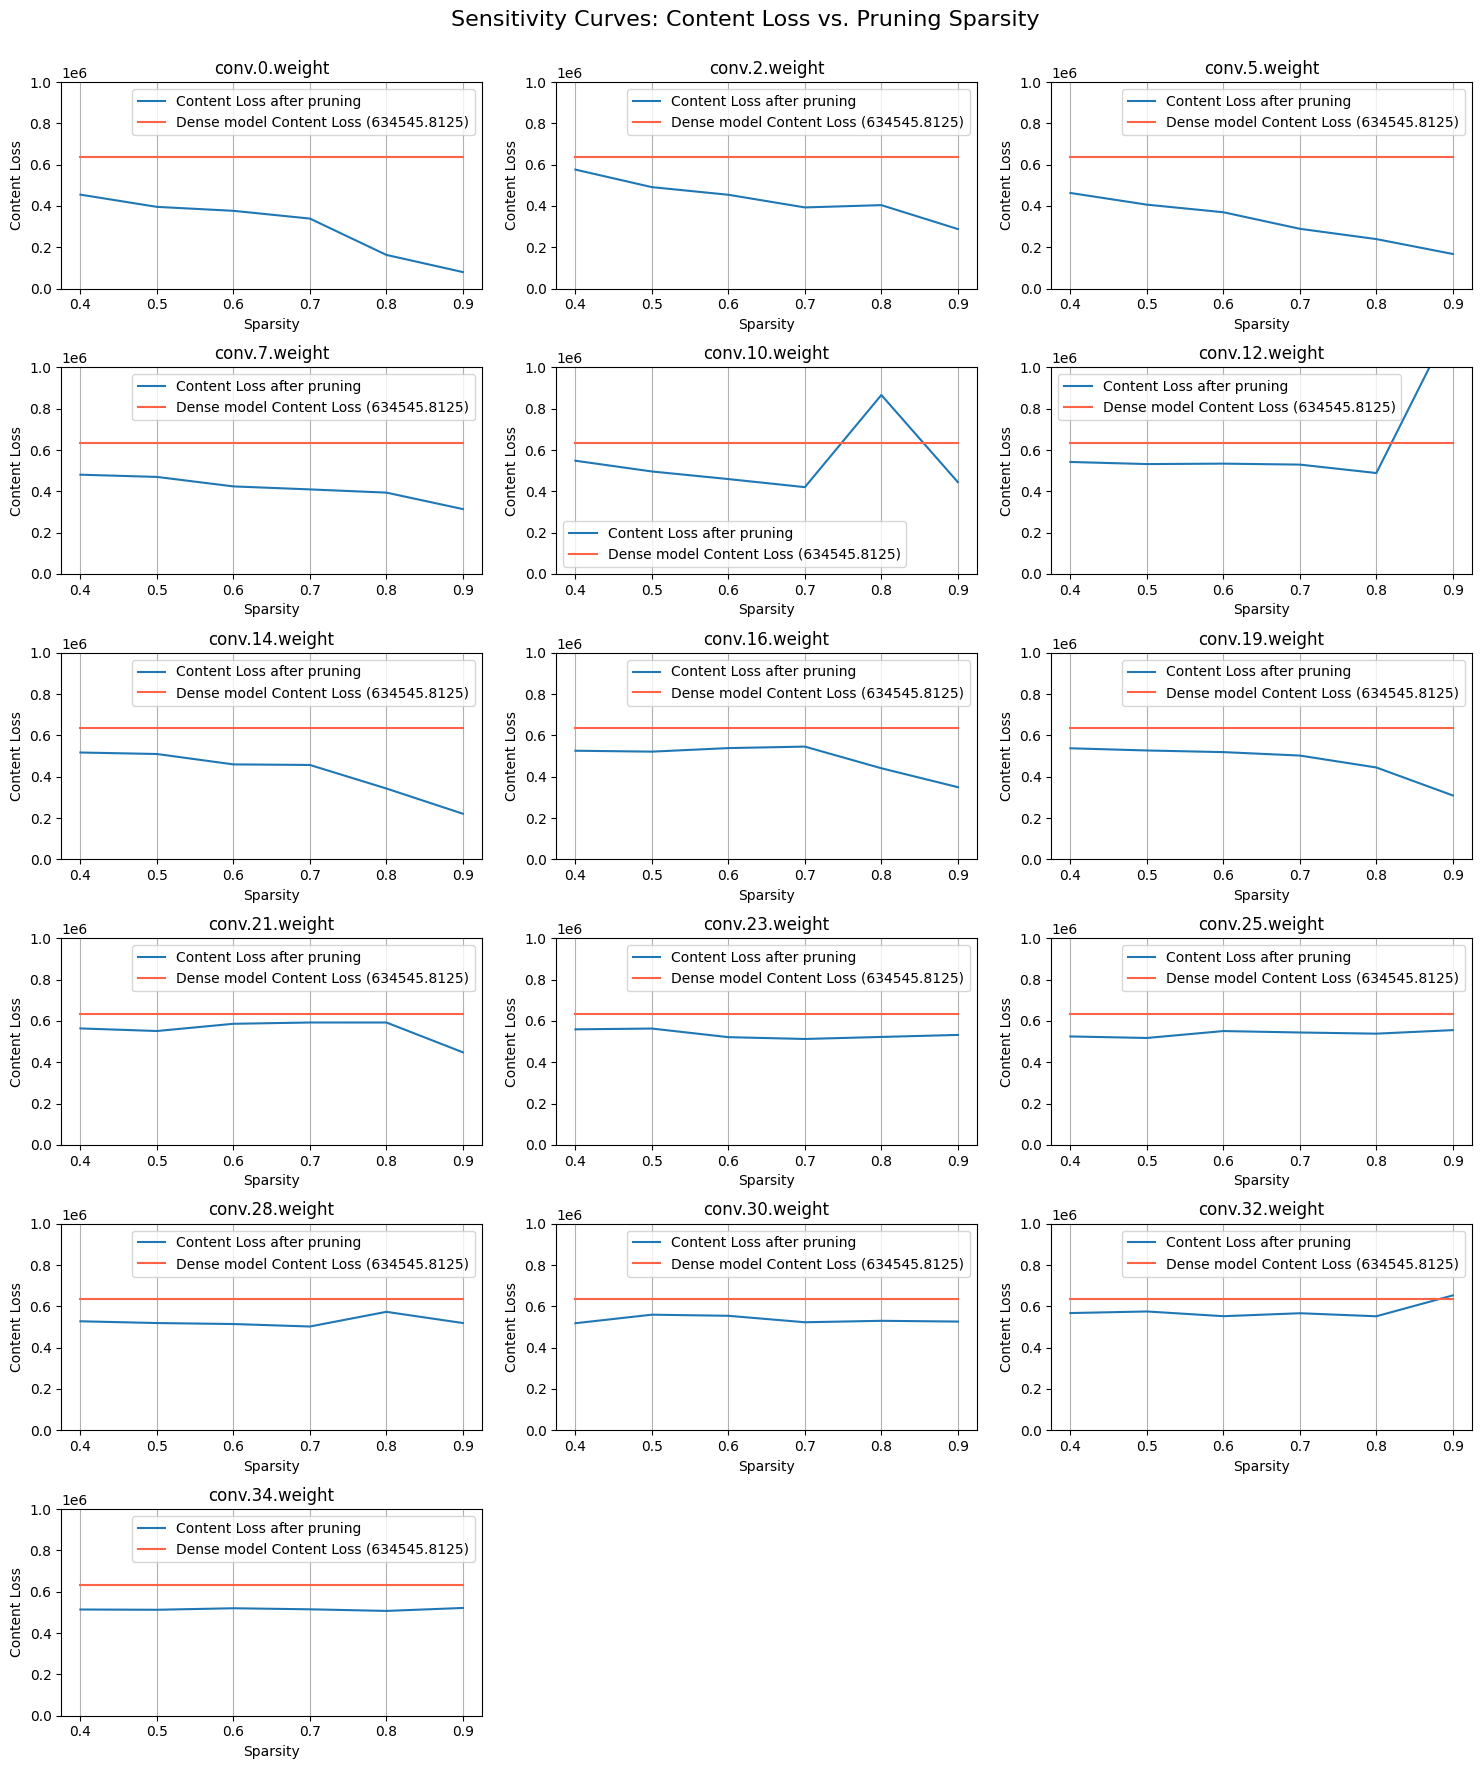

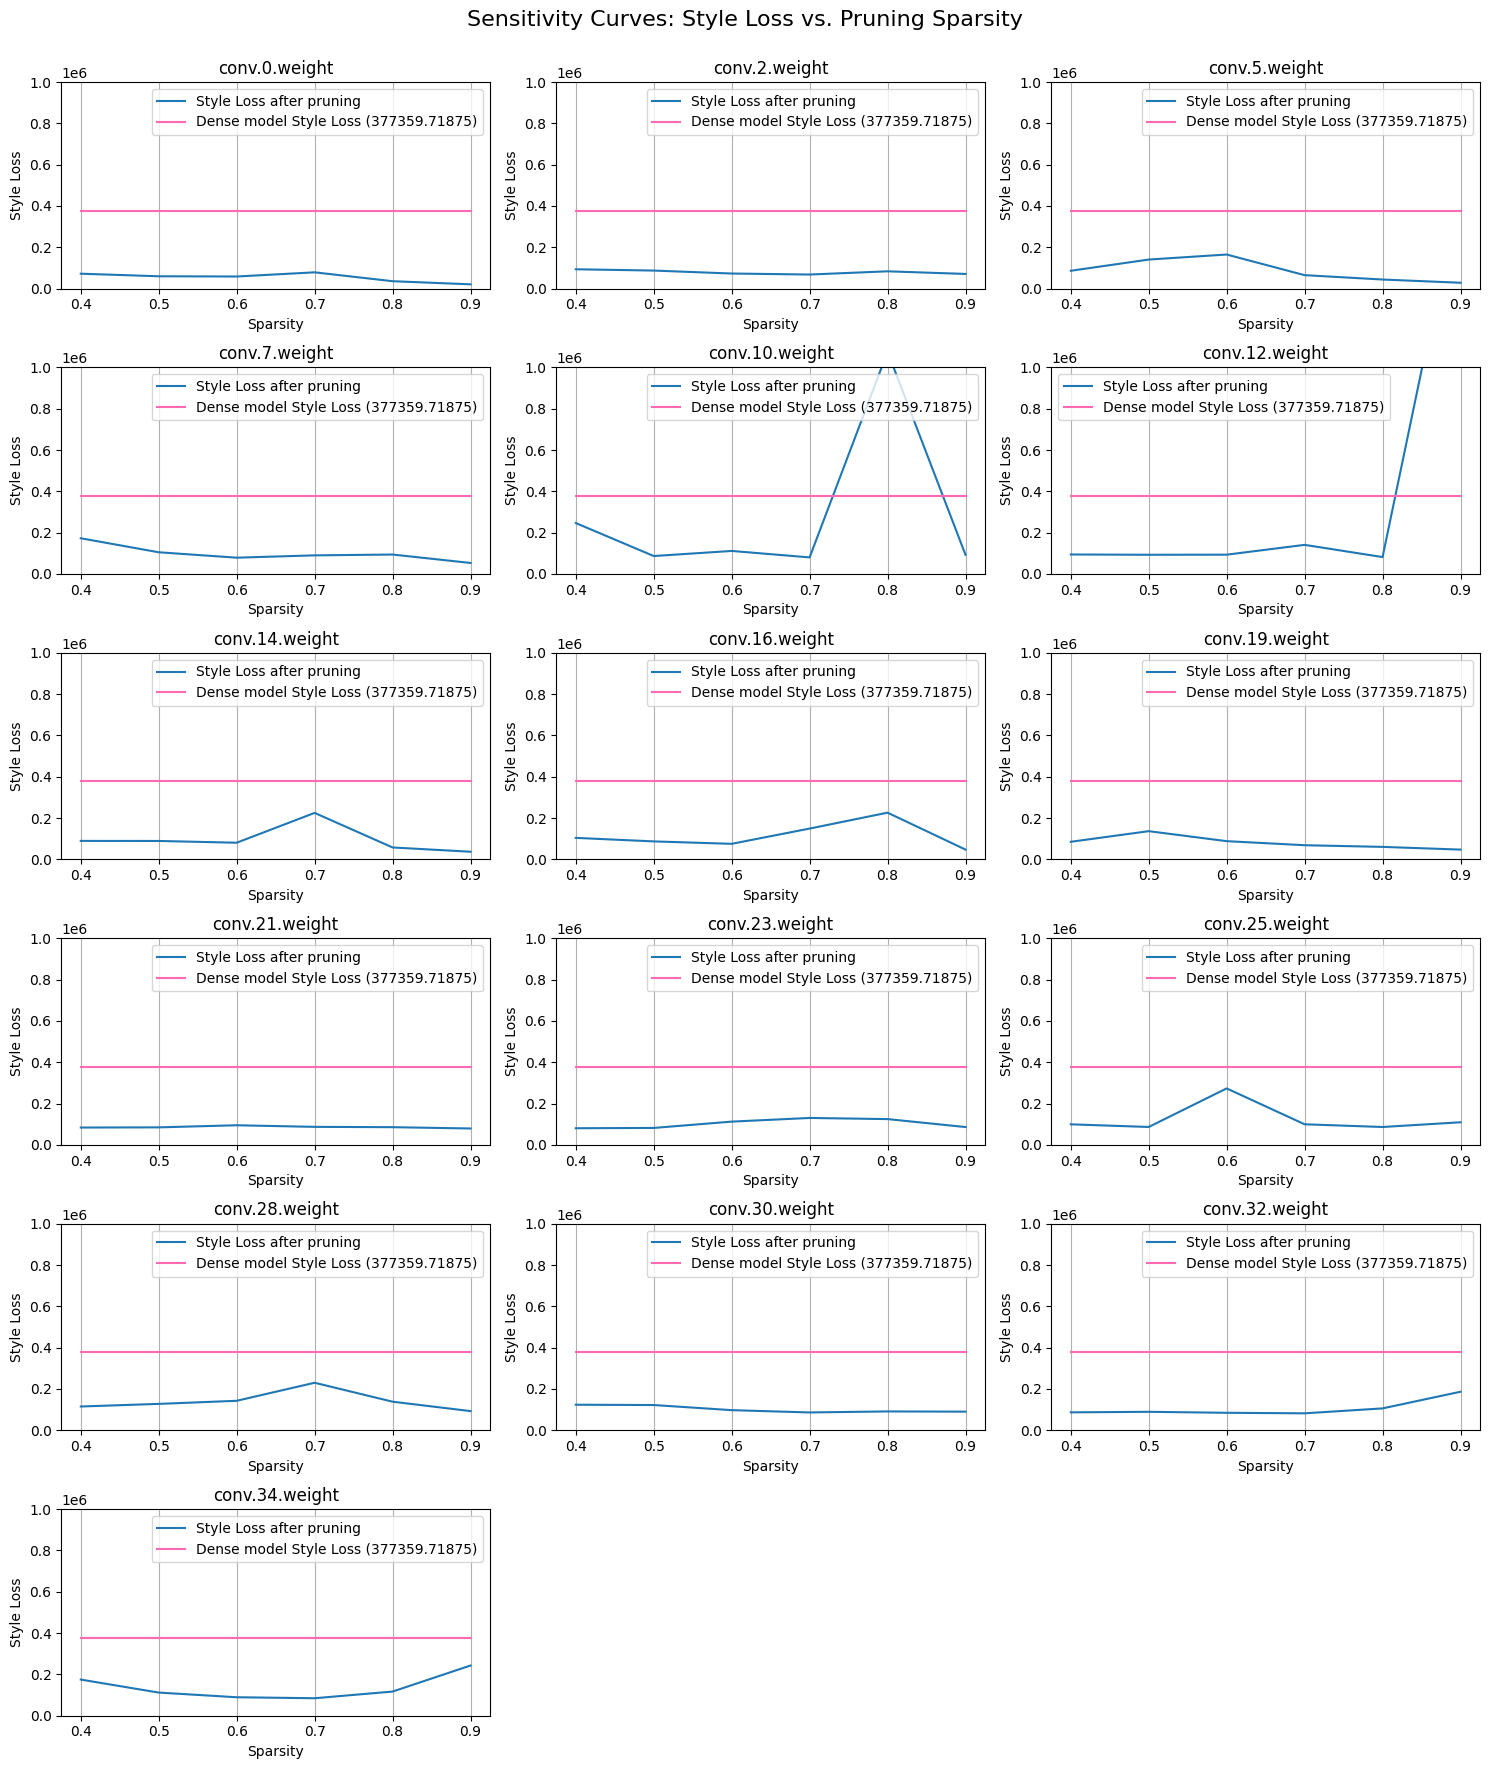

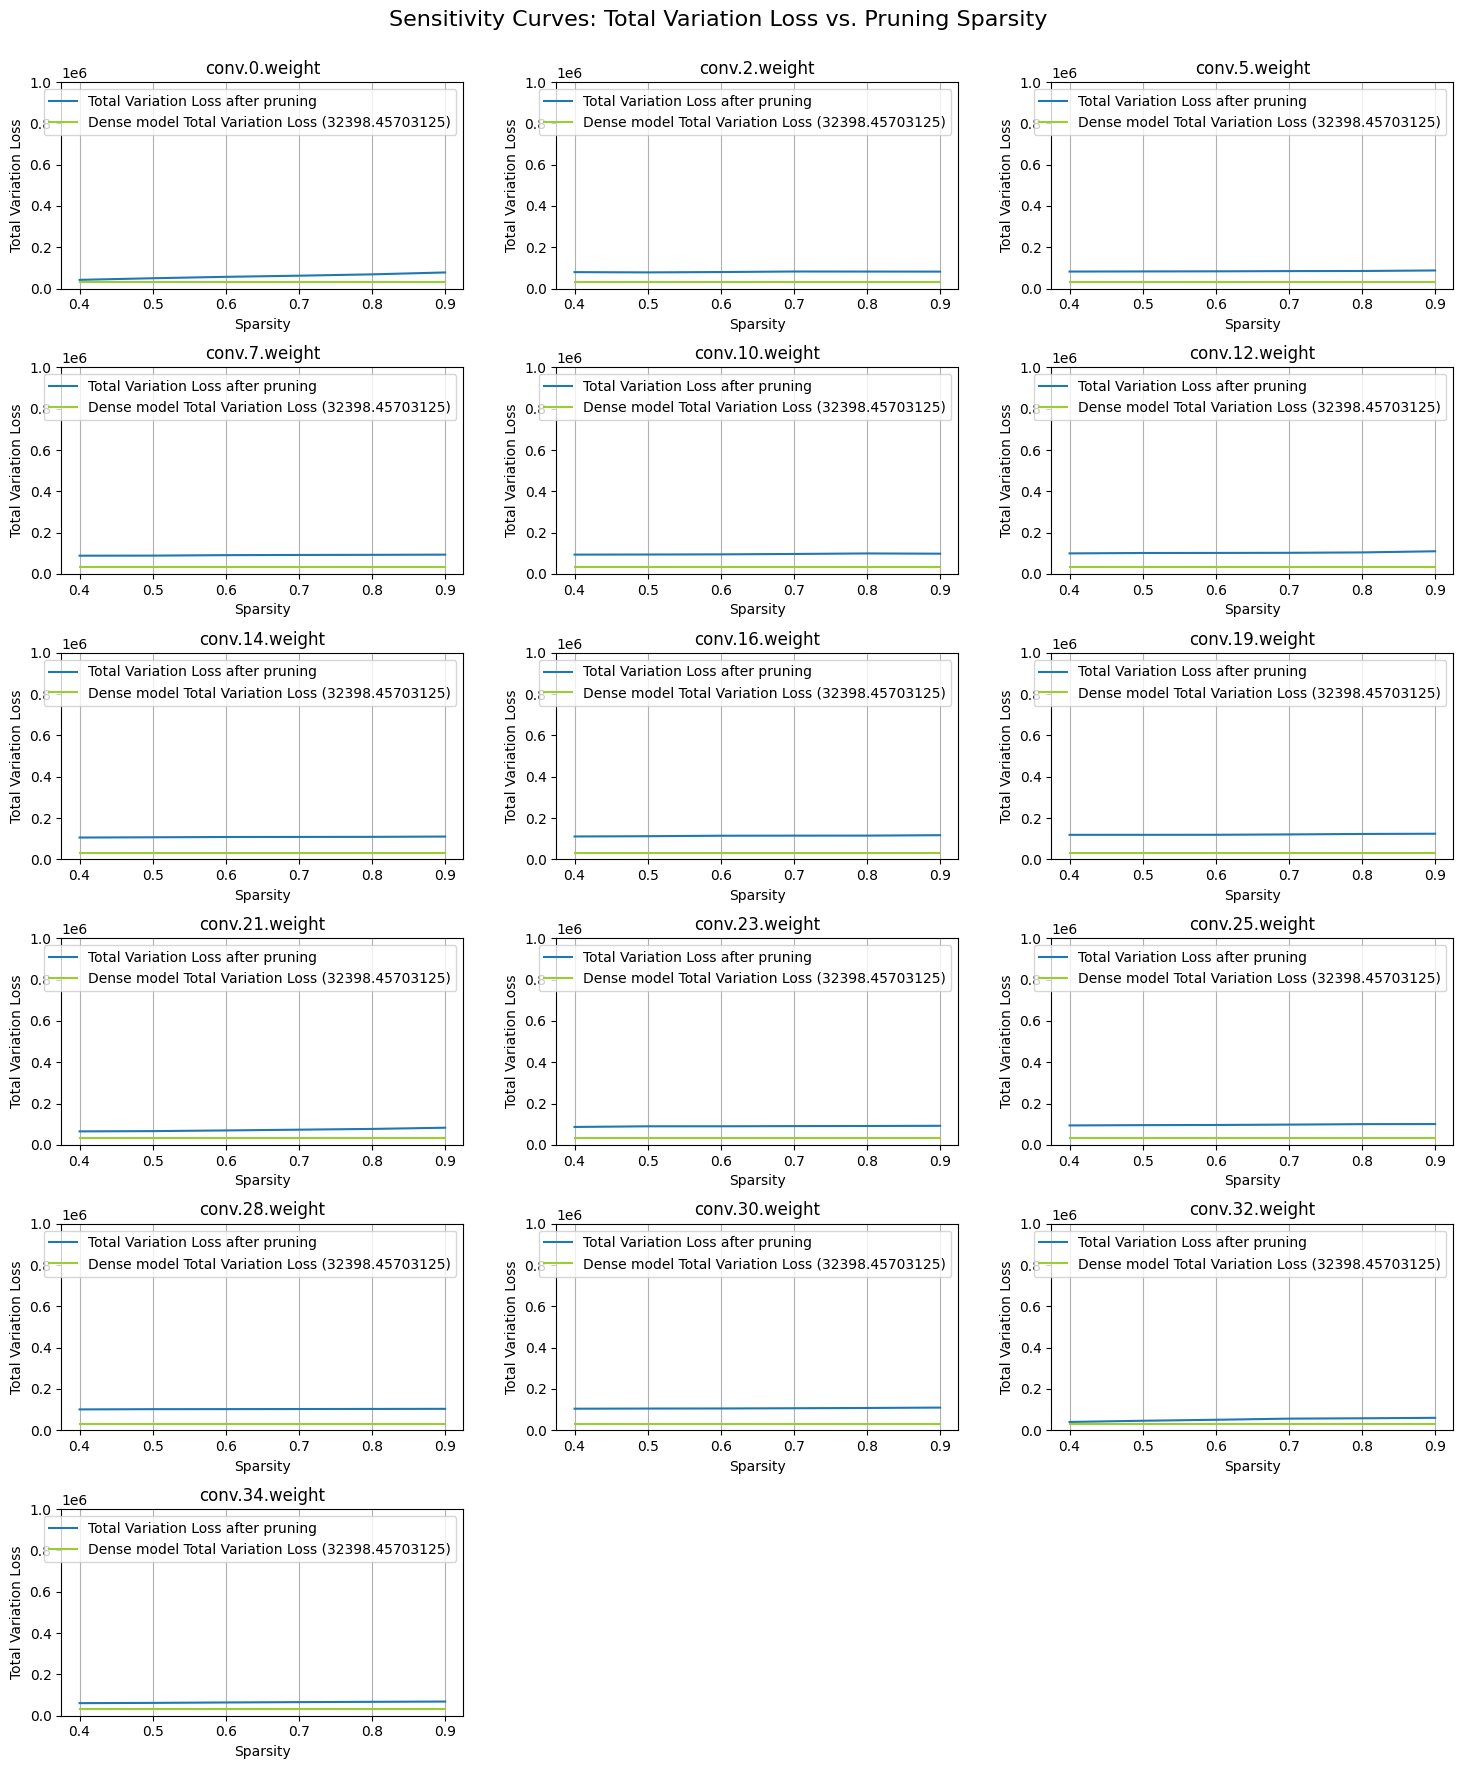

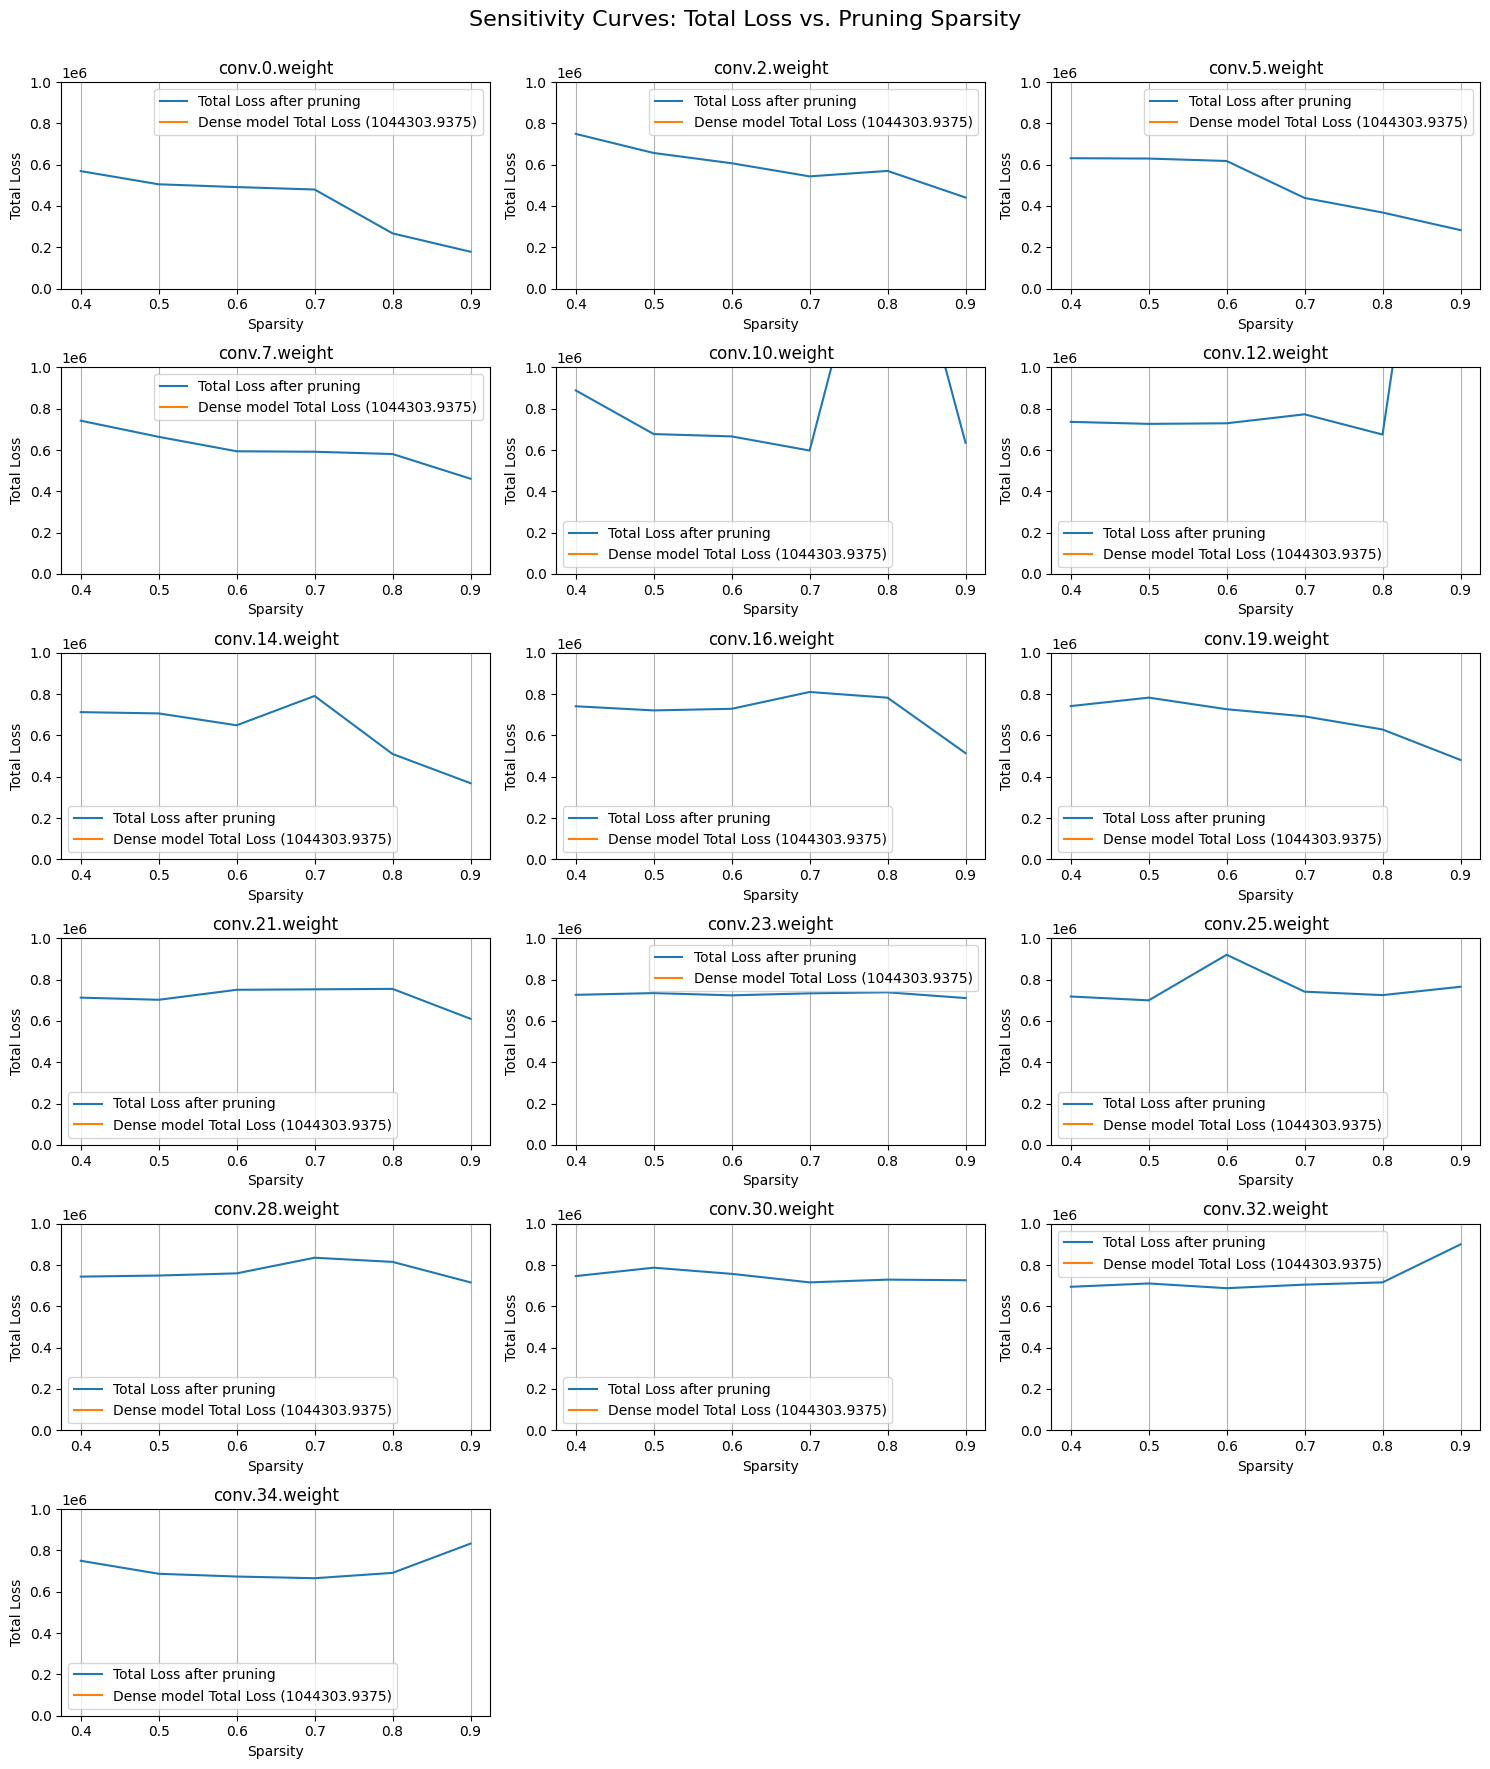

In [21]:
def plot_sensitivity_scan(sparsities,  pruned_model_losses, dense_model_loss, loss_name, color=None):
    # Calculate the number of rows needed for 3 columns
    num_parameters = len([param for name, param in model.named_parameters() if param.dim() > 1])
    num_rows = math.ceil(num_parameters / 3)

    # Create subplots with 3 columns
    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 3 * num_rows))
    axes = axes.ravel()

    param_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[param_index]

            # Plot total loss after pruning
            ax.plot(sparsities, pruned_model_losses[param_index], label=f'{loss_name} after pruning')

            # Plot dense model loss as a horizontal line
            ax.plot(sparsities, [dense_model_loss] * len(sparsities), label=f'Dense model {loss_name}', c=color)

            # Set xticks, ylimits, labels, title
            ax.set_xticks(np.arange(start=min(sparsities), stop=max(sparsities) + 0.1, step=0.1))
            ax.set_ylim(0, 1000000)  # Restored original Y-axis range
            ax.set_title(f'conv.{name}')
            ax.set_xlabel('Sparsity')
            ax.set_ylabel(f'{loss_name}')

            # Add legend and grid
            ax.legend([
                f'{loss_name} after pruning',
                f'Dense model {loss_name} ({dense_model_loss})'
            ])
            ax.grid(axis='x')

            param_index += 1

    # Turn off unused axes if the number of parameters is not a multiple of 3
    for i in range(len([param for name, param in model.named_parameters() if param.dim() > 1]), len(axes)):
        axes[i].axis('off')

    # Add overall plot title and adjust layout
    fig.suptitle(f'Sensitivity Curves: {loss_name} vs. Pruning Sparsity', fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.94)
    plt.show()

plot_sensitivity_scan(sparsities, content_losses, dense_model_content_loss, loss_name = 'Content Loss', color='tomato')
plot_sensitivity_scan(sparsities, style_losses, dense_model_style_loss, loss_name = 'Style Loss', color = 'hotpink')
plot_sensitivity_scan(sparsities, tv_losses, dense_model_tv_loss, loss_name = 'Total Variation Loss', color = 'yellowgreen')
plot_sensitivity_scan(sparsities, total_losses, dense_model_total_loss, loss_name = 'Total Loss')
